# Read list_meop.pkl and draw global maps

In [1]:
from pathlib import Path
import sys
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import cartopy.crs as ccrs
import cartopy.feature as cfea
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from itertools import islice

path_MEOP_analyses = os.fspath(Path.home() / 'MEOP_analyses/')
if not (path_MEOP_analyses in sys.path):
        sys.path.insert(0,path_MEOP_analyses)

import importlib
import meop
importlib.reload(meop)


<module 'meop' from '/home/jupyter-froqu/MEOP_analyses/meop.py'>

In [6]:
# filter list based on criteria in list_deployment
def filter_public_data(df):
    list_deployment = read_list_deployment()
    list_depl = {}
    list_smru_platform_code = []
    for smru_platform_code in df.index.levels[0]:
        depl = EXP_from_SMRU_CODE(smru_platform_code)
        if not (depl in list_depl):
            is_public = bool(list_deployment.loc[list_deployment['deployment_code'] == depl,['public']].values[0])
            list_depl[depl] = is_public
        if list_depl[depl]:
            list_smru_platform_code.append(smru_platform_code)
    return df.loc[list_smru_platform_code]


In [2]:
import regionmask
basins = regionmask.defined_regions.ar6.all
label = basins.names[44]
lon = np.arange(-179.5, 180)
lat = np.arange(-89.5, 90)
mask = basins.mask(lon,lat)

In [3]:
df = meop.read_list_data_in_MEOP("list_meop.pkl")
df = meop.filter_public_data(df)
df = df.loc[df['N_TEMP']!=0]

In [4]:
df_first = df.groupby('SMRU_PLATFORM_CODE').first()
df_first["MASK"] = df_first.apply(lambda row: mask.interp(lon=row['LONGITUDE'] , lat=row['LATITUDE'], method='nearest').values, axis=1)

In [5]:
df_first

,JULD,LATITUDE,LONGITUDE,N_TEMP,N_PSAL,N_CHLA,MASK
SMRU_PLATFORM_CODE,,,,,,,
awru1-A-06,2007-03-03 03:24:00,-68.5139,78.3736,12,0,0.0,44.0
awru1-B-06,2007-03-04 19:40:00,-68.4296,78.4134,12,0,0.0,44.0
awru1-C-06,2007-03-02 18:14:00,-68.4895,78.3249,12,0,0.0,44.0
bs1-53127-04,2004-10-15 11:01:00,-54.0183,-38.2190,12,0,0.0,57.0
bs1-53128-04,2004-10-11 18:19:00,-54.2359,-39.0737,12,0,0.0,57.0
...,...,...,...,...,...,...,...
wd10-678-17,2017-11-28 11:00:00,-66.5959,140.0797,16,16,0.0,44.0
wd10-679-17,2017-11-09 09:20:00,-66.6216,140.1138,16,16,0.0,44.0
wd10-681-17,2017-11-21 15:10:00,-66.6219,140.1069,16,16,0.0,44.0


In [14]:
for tag in df_first.index:
    index_mask = df_first.at[tag,'MASK']
    df.loc[tag,'MASK'] = index_mask

zones with data [44. 57.  3. 47. 42. 45.  6.  1. 15. 46.  0.  2. 10. 52. 50.  5. 16.]


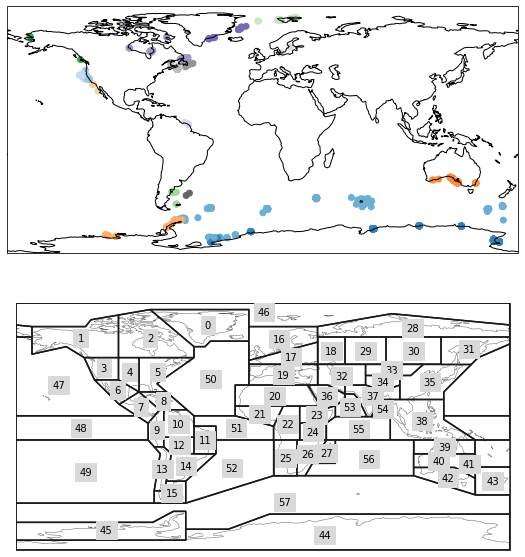

In [61]:
remapping = {v: k for k, v in enumerate(df.MASK.unique())}
df_first['MASK2'] = df_first['MASK'].replace(remapping)
f, ax = plt.subplots(2,1,subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(15,10))
ax[0].coastlines()
ax[0].scatter(x=df_first.LONGITUDE, y=df_first.LATITUDE, c=df_first.MASK2, \
            cmap=plt.cm.tab20c, transform=ccrs.PlateCarree())
basins.plot(ax=ax[1])
print('zones with data',df.MASK.unique())

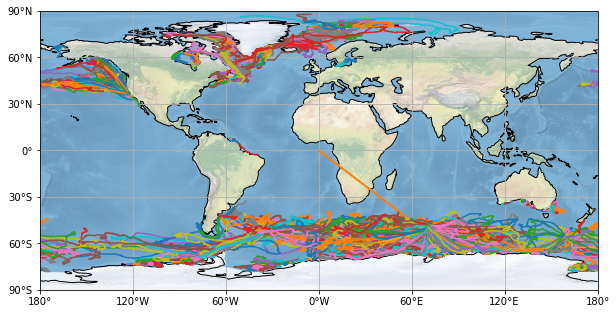

In [70]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

grouped = df.groupby('SMRU_PLATFORM_CODE')
for name,group in grouped:
    lon = np.where(np.abs(group['LONGITUDE'].diff())>100,np.nan,group['LONGITUDE'])
    lat = group['LATITUDE']
    ax.plot(lon,lat,transform=ccrs.PlateCarree())

ax.stock_img()
ax.coastlines()
ax.gridlines(xlocs=ax.get_xticks(),ylocs=ax.get_yticks())


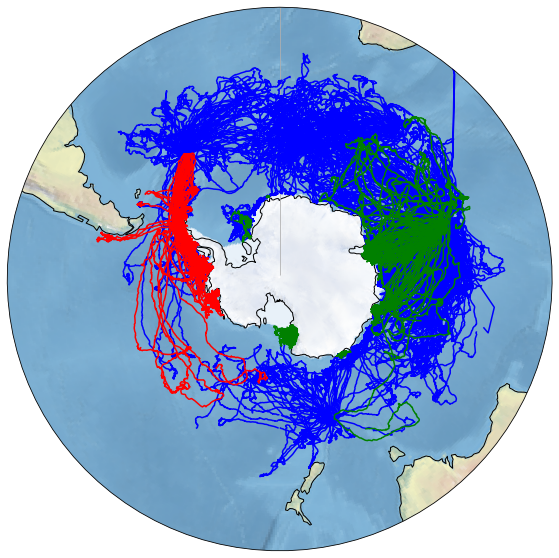

In [32]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

df2 = df.loc[df.MASK==57]
grouped = df2.groupby('SMRU_PLATFORM_CODE')
for name,group in grouped:
    lon = np.where(np.abs(group['LONGITUDE'].diff())>100,np.nan,group['LONGITUDE'])
    lat = group['LATITUDE']
    ax.plot(lon,lat,'b',transform=ccrs.PlateCarree())

df2 = df.loc[df.MASK==44]
grouped = df2.groupby('SMRU_PLATFORM_CODE')
for name,group in grouped:
    lon = np.where(np.abs(group['LONGITUDE'].diff())>100,np.nan,group['LONGITUDE'])
    lat = group['LATITUDE']
    ax.plot(lon,lat,'g',transform=ccrs.PlateCarree())

df2 = df.loc[df.MASK==45]
grouped = df2.groupby('SMRU_PLATFORM_CODE')
for name,group in grouped:
    lon = np.where(np.abs(group['LONGITUDE'].diff())>100,np.nan,group['LONGITUDE'])
    lat = group['LATITUDE']
    ax.plot(lon,lat,'r',transform=ccrs.PlateCarree())

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.gridlines(xlocs=ax.get_xticks(),ylocs=ax.get_yticks())


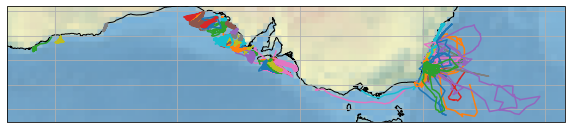

In [65]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))

df2 = df.loc[df.MASK==42]
grouped = df2.groupby('SMRU_PLATFORM_CODE')
for name,group in grouped:
    lon = np.where(np.abs(group['LONGITUDE'].diff())>100,np.nan,group['LONGITUDE'])
    lat = group['LATITUDE']
    ax.plot(lon,lat,transform=ccrs.PlateCarree())

#ax.set_extent([110, 160, -45, -25], ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.gridlines(xlocs=ax.get_xticks(),ylocs=ax.get_yticks())


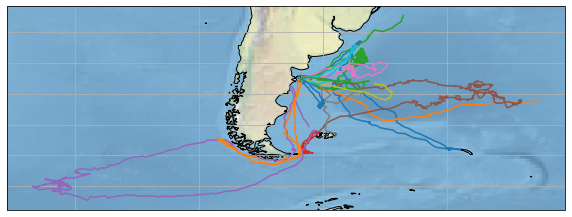

In [55]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))

df2 = df.loc[(df.MASK==15)|(df.MASK==52)]
grouped = df2.groupby('SMRU_PLATFORM_CODE')
for name,group in grouped:
    lon = np.where(np.abs(group['LONGITUDE'].diff())>100,np.nan,group['LONGITUDE'])
    lat = group['LATITUDE']
    ax.plot(lon,lat,transform=ccrs.PlateCarree())

#ax.set_extent([-90, -25, -60, -30], ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.gridlines(xlocs=ax.get_xticks(),ylocs=ax.get_yticks())


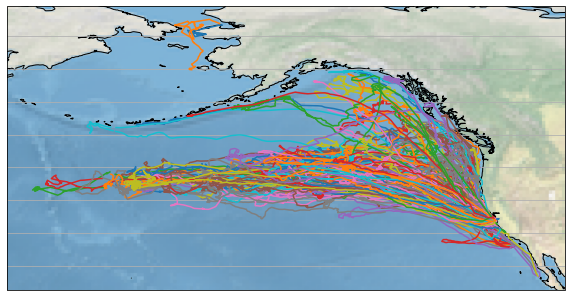

In [52]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))

df2 = df.loc[(df.MASK==47)|(df.MASK==6)|(df.MASK==3)|(df.MASK==1)]
grouped = df2.groupby('SMRU_PLATFORM_CODE')
for name,group in grouped:
    lon = np.where(np.abs(group['LONGITUDE'].diff())>100,np.nan,group['LONGITUDE'])
    lat = group['LATITUDE']
    ax.plot(lon,lat,transform=ccrs.PlateCarree())

#ax.set_extent([110, 160, -45, -25], ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.gridlines(xlocs=ax.get_xticks(),ylocs=ax.get_yticks())


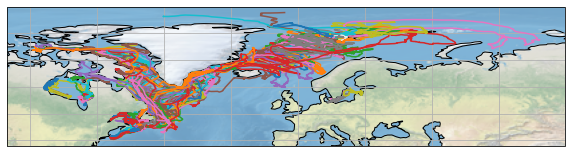

In [66]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))

df2 = df.loc[(df.MASK==0)|(df.MASK==2)|(df.MASK==5)|(df.MASK==50)|(df.MASK==46)|(df.MASK==16)]
grouped = df2.groupby('SMRU_PLATFORM_CODE')
for name,group in grouped:
    lon = np.where(np.abs(group['LONGITUDE'].diff())>100,np.nan,group['LONGITUDE'])
    lat = group['LATITUDE']
    ax.plot(lon,lat,transform=ccrs.PlateCarree())

#ax.set_extent([110, 160, -45, -25], ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.gridlines(xlocs=ax.get_xticks(),ylocs=ax.get_yticks())


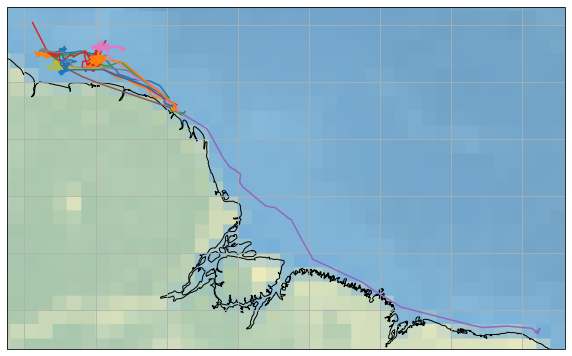

In [56]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))

df2 = df.loc[(df.MASK==10)]
grouped = df2.groupby('SMRU_PLATFORM_CODE')
for name,group in grouped:
    lon = np.where(np.abs(group['LONGITUDE'].diff())>100,np.nan,group['LONGITUDE'])
    lat = group['LATITUDE']
    ax.plot(lon,lat,transform=ccrs.PlateCarree())

#ax.set_extent([110, 160, -45, -25], ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.gridlines(xlocs=ax.get_xticks(),ylocs=ax.get_yticks())


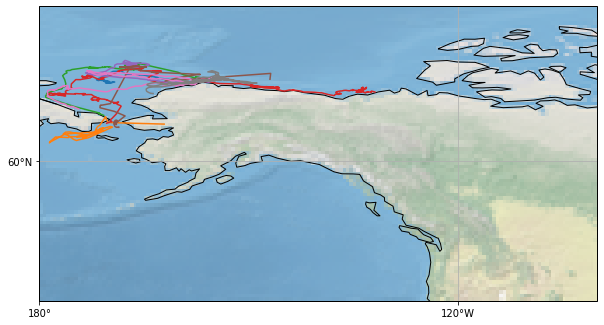

In [39]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

grouped = df.groupby('SMRU_PLATFORM_CODE')
for name,group in islice(grouped,10):
    lon = np.where(np.abs(group['LONGITUDE'].diff())>100,np.nan,group['LONGITUDE'])
    lat = group['LATITUDE']
    ax.plot(lon,lat,transform=ccrs.PlateCarree())

ax.set_extent([-180, -100, 40, 80])
ax.stock_img()
ax.coastlines()
ax.gridlines(xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
plt.show()
